<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/(ToTensor)Strong_STL_10__DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set Dataset and model

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision import utils
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import time
import os


In [3]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [4]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [5]:
def Get_psnr(input, output, max_val=1.0):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().clone().detach().numpy()
    output = output.cpu().clone().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [6]:
batch_size = 16
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [7]:
strong_transform = transforms.Compose([
                    transforms.ToTensor(),                     
                    transforms.GaussianBlur(kernel_size=(7,7),sigma=3), #
])

# weak/moderate/strong DataSet

Original Train/Validation/Test dataset

In [11]:
org_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = transforms.ToTensor(), download=True)
tr_subset, val_subset = torch.utils.data.random_split(org_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
test_set = datasets.STL10(root = "./data", split = "test",transform = transforms.ToTensor(), download=True)



  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


# PILToTensor와 ToTensor의 차이, 
전자는 정규화를 하지 않는다.
0 부터 255인 uint8(그러므로 나중에 신경망에 넣을 때 float 변환 필요), 후자는 정규화를 하여서 0부터 1인 float가 된다.

단계를 나누어서 이미지에 노이즈를 가해보자

# opencv Gaussian blur를 가해보자.

Strong_hat Train/Validation/Test dataset


In [15]:
strong_hat_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = strong_transform, download=False)
strong_hat_tr_subset, strong_hat_val_subset = torch.utils.data.random_split(strong_hat_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
strong_hat_test_set = datasets.STL10(root = "./data", split = "test",transform = strong_transform, download=False)

# Check Image blur strengthen visaulazaiton

# Original / Gaussian Blur DataLoader

In [17]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)

val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)

test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 4, pin_memory=True)


# Moderate Gaussian Blur DataLoader

# Strong Gaussian Blur

In [19]:
strong_hat_tr_dataloader = DataLoader(strong_hat_tr_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)
strong_hat_val_dataloader = DataLoader(strong_hat_val_subset, batch_size = batch_size, num_workers = 4, pin_memory=True) # 여기서 hat_val_subset을 안 넣는 치명적인 실수.
strong_hat_test_dataloader = DataLoader(strong_hat_test_set, batch_size = batch_size, num_workers = 4, pin_memory=True)

In [20]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


# Model. Setting parameter -> float

In [21]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
    #48 by 48 by 32
        nn.ReLU(True),


        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 

        nn.ReLU(True),

        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
    # 6 by 6 by 256
        nn.ReLU(True),
    )
    self.decoder = nn.Sequential(
 
        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 12 by 12 by 128  
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 24 by 24 by 64

        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),        
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Strong DAE train Mode

cuda
Epoch : [1/20] 

Training Loss: 0.013099	 validation Loss 0.009872
Epoch : [2/20] 

Training Loss: 0.009841	 validation Loss 0.009788
Epoch : [3/20] 

Training Loss: 0.009753	 validation Loss 0.009631
Epoch : [4/20] 

Training Loss: 0.009701	 validation Loss 0.009665
Epoch : [5/20] 

Training Loss: 0.009670	 validation Loss 0.009740
PNSR :67.66 	 SSIM : 0.60
PNSR :65.04 	 SSIM : 0.47
PNSR :65.76 	 SSIM : 0.58
PNSR :73.95 	 SSIM : 0.77
PNSR :58.64 	 SSIM : 0.48


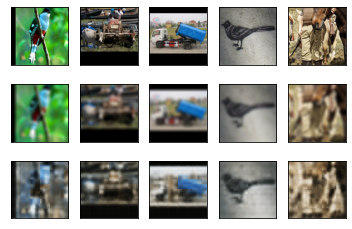

Epoch : [6/20] 

Training Loss: 0.009650	 validation Loss 0.009652
Epoch : [7/20] 

Training Loss: 0.009634	 validation Loss 0.009628
Epoch : [8/20] 

Training Loss: 0.009623	 validation Loss 0.009569
Epoch : [9/20] 

Training Loss: 0.009618	 validation Loss 0.009586
Epoch : [10/20] 

Training Loss: 0.009614	 validation Loss 0.009546
PNSR :67.80 	 SSIM : 0.61
PNSR :65.11 	 SSIM : 0.47
PNSR :66.09 	 SSIM : 0.58
PNSR :73.76 	 SSIM : 0.77
PNSR :58.56 	 SSIM : 0.48


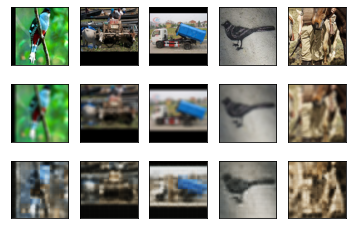

Epoch : [11/20] 

Training Loss: 0.009607	 validation Loss 0.009543
Epoch : [12/20] 

Training Loss: 0.009600	 validation Loss 0.009538
Epoch : [13/20] 

Training Loss: 0.009595	 validation Loss 0.009533
Epoch : [14/20] 

Training Loss: 0.009589	 validation Loss 0.009531
Epoch : [15/20] 

Training Loss: 0.009585	 validation Loss 0.009533
PNSR :67.95 	 SSIM : 0.61
PNSR :65.08 	 SSIM : 0.47
PNSR :66.07 	 SSIM : 0.59
PNSR :73.78 	 SSIM : 0.77
PNSR :58.57 	 SSIM : 0.48


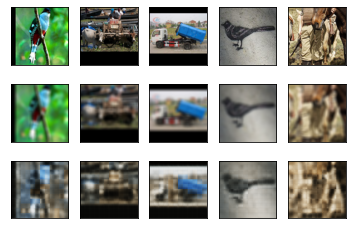

Epoch : [16/20] 

Training Loss: 0.009583	 validation Loss 0.009530
Epoch : [17/20] 

Training Loss: 0.009580	 validation Loss 0.009525
Epoch : [18/20] 

Training Loss: 0.009577	 validation Loss 0.009525
Epoch : [19/20] 

Training Loss: 0.009574	 validation Loss 0.009524
Epoch : [20/20] 

Training Loss: 0.009570	 validation Loss 0.009517
PNSR :68.30 	 SSIM : 0.61
PNSR :65.12 	 SSIM : 0.47
PNSR :66.13 	 SSIM : 0.59
PNSR :73.85 	 SSIM : 0.77
PNSR :58.55 	 SSIM : 0.48


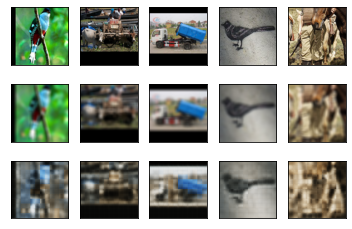

execution time : 28.3min


In [22]:

n_epochs = 20

device = get_device()
print(device)

model_strong = DenosingAutoencoder()
optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
model_strong=model_strong.to(device)

strong_train_loss_graph = np.array([])
strong_val_loss_graph = np.array([])




start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_strong.train()
    time.sleep(1.0)
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_loss = 0.0
    total_val_loss = 0.0

    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''
    #Training
    for i,(tr_img, hat_img) in enumerate(zip(tr_dataloader,strong_hat_tr_dataloader)):
        tr_images,_ = tr_img
#        print(tr_images_arr.shape)
        hat_tr_images,_ = hat_img
#check   print(type(hat_tr_images))
        hat_tr_images = hat_tr_images.to(device) #데이터 형식이 Byte이기 때문에 신경망 성분인 float으로 변환해야 한다.
#check   print(tr_images.shape)
        tr_outputs =model_strong(hat_tr_images)
        optimizer_strong.zero_grad()
#check0. print(hat_tr_images.shape)  
#check   print(tr_outputs.shape)
        tr_images = tr_images.to(device)
        loss = mse_loss(tr_outputs, tr_images).to(device) #여기에 쿠다를 부착하니 성능 급 상승함.
        loss.backward()#.to(device)
        optimizer_strong.step()
        train_loss = loss.clone().detach().item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_dataloader)
    strong_train_loss_graph = np.append(strong_train_loss_graph, total_train_loss)

    
    #evaluation
    model_strong.eval()
    time.sleep(1.0)
    with torch.no_grad():   
        optimizer_strong.zero_grad()
        
        for i, (img, hat_img) in enumerate(zip(val_dataloader, strong_hat_val_dataloader)):
                val_img, _ = img
                hat_val_img,_ = hat_img
                 
                hat_val_img = hat_val_img.to(device)
                val_outputs =model_strong(hat_val_img)
#                print('val_outputs shape:',val_outputs.shape )
                val_img = val_img.to(device)
                val_loss = mse_loss(val_outputs, val_img)#.to(device)
                val_loss = val_loss.item()
                total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_dataloader)
        strong_val_loss_graph = np.append(strong_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
        if (epoch)%5 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(val_img[j], val_outputs[j])
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(val_outputs[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()

total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

# strong test

In [23]:

Gs_blur_strong_test_dataset = []

for j in range(8000):
  hat_img_test_set_arr = cv2.GaussianBlur(img_test_set_arr[j], (41,41),0)
  hat_img_test_set_tensor_byte = torch.from_numpy(hat_img_test_set_arr)
  hat_img_test_set_tensor_float = hat_img_test_set_tensor_byte.float()
  hat_img_test_set_tensor_normal = hat_img_test_set_tensor_float.div(255.0)
  Gs_blur_strong_test_dataset.append([hat_img_test_set_tensor_normal,0])

Gs_blur_strong_test_dataloader = DataLoader(Gs_blur_strong_test_dataset, batch_size = batch_size, num_workers = 4)

NameError: ignored

# strong graph

# test graph for (average psnr, ssim)

In [ ]:
from skimage.metrics import structural_similarity as ssim

sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_strong.eval()
with torch.no_grad():
    optimizer_strong.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_strong_test_dataloader)):
        
        strong_test_img, _ = test_img
        strong_test_img = strong_test_img.to(device)
        strong_test_hat_img, _ = hat_test_img
        strong_test_hat_img = strong_test_hat_img.to(device)

        test_outputs = model_strong(strong_test_hat_img)
        
    for j in range(10):
        img1_cpu = strong_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        strong_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        strong_psnr = Get_psnr(strong_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=strong_psnr
        sum_ssim+=strong_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(strong_psnr,strong_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(strong_test_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(strong_test_hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(test_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))


In [ ]:
data = iter(Gs_blur_strong_val_dataloader)
img,_ = next(data)
img_uint8 = img[0].numpy().astype('uint8')

plt.imshow(img_uint8.transpose(1,2,0))
img[0]

In [ ]:
print(img[0].shape)